# HW 11

I use 311 data that I downloaded from NYC Open Data. The data have been filtered by complaint type of residential noising from 2010 until now. In this assignment, the data will be cover only between 2014 to 2018.

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import urllib
import requests
import os
import io
import json
import pylab as pl
import shapely
from fiona.crs import from_epsg
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
!ls

HW11_A1.ipynb  Ridetypes.png  subway_timeseries_instructions2.ipynb


In [3]:
!mv 311_Service_Requests_from_2010_to_Present.csv $PUIDATA

mv: cannot stat '311_Service_Requests_from_2010_to_Present.csv': No such file or directory


In [4]:
!ls $PUIDATA

201501-citibike-tripdata.csv
201502-citibike-tripdata.csv
201502-citibike-tripdata.zip
201506-citibike-tripdata.csv
201506-citibike-tripdata.zip
201801-citibike-tripdata.csv
201801-citibike-tripdata.zip
201806-citibike-tripdata.zip
201808-citibike-tripdata.zip
311_Service_Requests_from_2010_to_Present.csv
ACS_16_1YR_B02001_with_ann.csv
ACS_16_1YR_GCT2801.ST50_with_ann.csv
acs16_final.csv
ACS_17_1YR_GCT2801.ST51_with_ann.csv
API_NY.GDP.MKTP.CD_DS2_en_csv_v2_10203569.csv
API_SP.POP.TOTL_DS2_en_csv_v2_10203548.csv
Asc.csv
BK_18v1.csv
data-pvLFI.csv
Energy_and_Water_Data_Disclosure_for_Local_Law_84_2014__Data_for_Calendar_Year_2013_.csv
file.gz
geo_export_0538411f-ba8f-4f39-8d03-452cf509b368.dbf
geo_export_0538411f-ba8f-4f39-8d03-452cf509b368.prj
geo_export_0538411f-ba8f-4f39-8d03-452cf509b368.shp
geo_export_0538411f-ba8f-4f39-8d03-452cf509b368.shx
geo_export_07042bf8-782d-4cc1-ae07-585eb9919134.dbf
geo_export_07042bf8-782d-4cc1-ae07-585eb9919134.prj
geo_export_07042bf8-782d-4cc1-ae07-585e

In [5]:
data = pd.read_csv("%s/311_Service_Requests_from_2010_to_Present.csv"%os.getenv("PUIDATA"))
data.head(2)

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location
0,15633017,01/01/2010 05:11:21 AM,01/01/2010 05:49:07 AM,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,10306.0,209 JEFFERSON STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.586936,-74.100795,"(40.586935653896624, -74.10079531128014)"
1,15633019,01/01/2010 05:36:30 AM,01/01/2010 06:38:00 AM,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,11374.0,65-41 SAUNDERS STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.727562,-73.858060,"(40.72756234995973, -73.85805982707932)"


In [6]:
data.columns

Index(['Unique Key', 'Created Date', 'Closed Date', 'Agency', 'Agency Name',
       'Complaint Type', 'Descriptor', 'Location Type', 'Incident Zip',
       'Incident Address', 'Street Name', 'Cross Street 1', 'Cross Street 2',
       'Intersection Street 1', 'Intersection Street 2', 'Address Type',
       'City', 'Landmark', 'Facility Type', 'Status', 'Due Date',
       'Resolution Description', 'Resolution Action Updated Date',
       'Community Board', 'BBL', 'Borough', 'X Coordinate (State Plane)',
       'Y Coordinate (State Plane)', 'Open Data Channel Type',
       'Park Facility Name', 'Park Borough', 'Vehicle Type',
       'Taxi Company Borough', 'Taxi Pick Up Location', 'Bridge Highway Name',
       'Bridge Highway Direction', 'Road Ramp', 'Bridge Highway Segment',
       'Latitude', 'Longitude', 'Location'],
      dtype='object')

In [7]:
# data cleaning 
data = data[['Created Date','Descriptor','Incident Zip','Borough','Latitude','Longitude']]
data.rename(columns={"Created Date":"Date","Incident Zip":"Zipcode"}, inplace=True)
# eliminate all zip code outside NYC and change to integer
data = data[data['Zipcode'] < 12000 ]
data['Zipcode'] = data.Zipcode.astype(int)
data.head(2)

,Date,Descriptor,Zipcode,Borough,Latitude,Longitude
0,01/01/2010 05:11:21 AM,Loud Music/Party,10306,STATEN ISLAND,40.586936,-74.100795
1,01/01/2010 05:36:30 AM,Loud Music/Party,11374,QUEENS,40.727562,-73.858060


In [8]:
type(data.Date[2])

str

In [9]:
# set datetime
data['Date'] = data['Date'].str[:19]
data['Date'] = pd.to_datetime(data.Date)
data['Year'] = data['Date'].dt.strftime('%Y')
data['YearMonth'] = data['Date'].dt.strftime('%Y/%m')
data['Month'] = data['Date'].dt.strftime('%b')

In [10]:
data.head()

,Date,Descriptor,Zipcode,Borough,Latitude,Longitude,Year,YearMonth,Month
0,2010-01-01 05:11:21,Loud Music/Party,10306,STATEN ISLAND,40.586936,-74.100795,2010,2010/01,Jan
1,2010-01-01 05:36:30,Loud Music/Party,11374,QUEENS,40.727562,-73.858060,2010,2010/01,Jan
2,2010-01-01 06:23:19,Loud Music/Party,11372,QUEENS,40.748883,-73.882264,2010,2010/01,Jan
3,2010-01-01 07:50:01,Banging/Pounding,10001,MANHATTAN,40.750091,-73.996239,2010,2010/01,Jan
4,2010-01-01 07:57:20,Loud Music/Party,11372,QUEENS,40.751694,-73.881811,2010,2010/01,Jan


In [11]:
data.shape

(1542529, 9)

In [12]:
type(data.Year[2])

str

In [13]:
data2014 = data[data['Year']=='2014']
data2015 = data[data['Year']=='2015']
data2016 = data[data['Year']=='2016']
data2017 = data[data['Year']=='2017']
data2018 = data[data['Year']=='2018']

df14 = data2014.groupby(['Zipcode']).size().reset_index()
df15 = data2015.groupby(['Zipcode']).size().reset_index()
df16 = data2016.groupby(['Zipcode']).size().reset_index()
df17 = data2017.groupby(['Zipcode']).size().reset_index()
df18 = data2018.groupby(['Zipcode']).size().reset_index()

m1 = pd.merge(df14, df15, on='Zipcode', how='inner') 
m2 = pd.merge(df16, df17, on='Zipcode', how='inner') 
m3 = pd.merge(m1, m2, on='Zipcode', how='inner') 
m4 = pd.merge(m3, df18, on='Zipcode', how='inner') 

df = pd.merge(m3, m4, on='Zipcode', how='inner') 
df.columns = ['Zipcode', '2014', '2015', '2016', '2017','?','!','~',',', '2018']
df.drop(['?','!','~',','],axis=1, inplace=True)
df.head()

,Zipcode,2014,2015,2016,2017,2018
0,10001,430,602,949,802,705
1,10002,1956,2549,2381,2791,1755
2,10003,1201,1370,1450,1331,995
3,10004,23,24,35,29,16
4,10005,85,60,80,67,68


In [14]:
d2014=data2014.groupby(['YearMonth']).count()
d2015=data2015.groupby(['YearMonth']).count()
d2016=data2016.groupby(['YearMonth']).count()
d2017=data2017.groupby(['YearMonth']).count()
d2018=data2018.groupby(['YearMonth']).count()

In [15]:
d2014['Date'] = ['January', 'February', 'March', 'April', 'May','June','July','August','September','October', 'November', 'December']
d2014['Year'] = ['2014'] * 12
d2014 = d2014.drop(['Zipcode', 'Borough', 'Latitude', 'Longitude',
        'Month'], axis=1)
d2014.rename(columns={"Descriptor":"Loud Music/Party"},inplace=True)

d2015['Date'] = ['January', 'February', 'March', 'April', 'May','June','July','August','September','October', 'November', 'December']
d2015['Year'] = ['2015'] * 12
d2015 = d2015.drop(['Zipcode', 'Borough', 'Latitude', 'Longitude',
        'Month'], axis=1)
d2015.rename(columns={"Descriptor":"Loud Music/Party"},inplace=True)

d2016['Date'] = ['January', 'February', 'March', 'April', 'May','June','July','August','September','October', 'November', 'December']
d2016['Year'] = ['2016'] * 12
d2016 = d2016.drop(['Zipcode', 'Borough', 'Latitude', 'Longitude',
        'Month'], axis=1)
d2016.rename(columns={"Descriptor":"Loud Music/Party"},inplace=True)

d2017['Date'] = ['January', 'February', 'March', 'April', 'May','June','July','August','September','October', 'November', 'December']
d2017['Year'] = ['2017'] * 12
d2017 = d2017.drop(['Zipcode', 'Borough', 'Latitude', 'Longitude',
        'Month'], axis=1)
d2017.rename(columns={"Descriptor":"Loud Music/Party"},inplace=True)

d2018['Date'] = ['January', 'February', 'March', 'April', 'May','June','July','August','September','October', 'November']
d2018['Year'] = ['2018'] * 11
d2018 = d2018.drop(['Zipcode', 'Borough', 'Latitude', 'Longitude',
        'Month'], axis=1)
d2018.rename(columns={"Descriptor":"Loud Music/Party"},inplace=True)

In [16]:
# Concatenating
frames = [d2014, d2015,d2016,d2017,d2018]
df = pd.concat(frames)

In [17]:
df.columns = ['Months', 'Frequency', 'Year']
df.head()

,Months,Frequency,Year
YearMonth,,,
2014/01,January,12205,2014
2014/02,February,11905,2014
2014/03,March,13339,2014
2014/04,April,13875,2014
2014/05,May,19036,2014


In [18]:
table = df.pivot_table(index='Year',columns='Months',values='Frequency')
table

Months,April,August,December,February,January,July,June,March,May,November,October,September
Year,,,,,,,,,,,,
2014,13875.0,20622.0,15463.0,11905.0,12205.0,16884.0,19644.0,13339.0,19036.0,15869.0,16806.0,16856.0
2015,16083.0,19478.0,17400.0,13284.0,15313.0,17448.0,18419.0,14941.0,22561.0,16118.0,16737.0,18933.0
2016,18855.0,17255.0,17543.0,14467.0,15930.0,21058.0,20870.0,16121.0,22704.0,16357.0,19264.0,20792.0
2017,20559.0,19812.0,17500.0,15444.0,17892.0,21455.0,21578.0,16197.0,20941.0,16448.0,20465.0,21567.0
2018,18019.0,16506.0,NaN,15307.0,16683.0,19168.0,21348.0,17064.0,20816.0,2318.0,17635.0,20934.0


In [19]:
table=table[['January', 'February', 'March', 'April', 'May','June','July','August','September','October', 'November', 'December']]
table

Months,January,February,March,April,May,June,July,August,September,October,November,December
Year,,,,,,,,,,,,
2014,12205.0,11905.0,13339.0,13875.0,19036.0,19644.0,16884.0,20622.0,16856.0,16806.0,15869.0,15463.0
2015,15313.0,13284.0,14941.0,16083.0,22561.0,18419.0,17448.0,19478.0,18933.0,16737.0,16118.0,17400.0
2016,15930.0,14467.0,16121.0,18855.0,22704.0,20870.0,21058.0,17255.0,20792.0,19264.0,16357.0,17543.0
2017,17892.0,15444.0,16197.0,20559.0,20941.0,21578.0,21455.0,19812.0,21567.0,20465.0,16448.0,17500.0
2018,16683.0,15307.0,17064.0,18019.0,20816.0,21348.0,19168.0,16506.0,20934.0,17635.0,2318.0,NaN


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


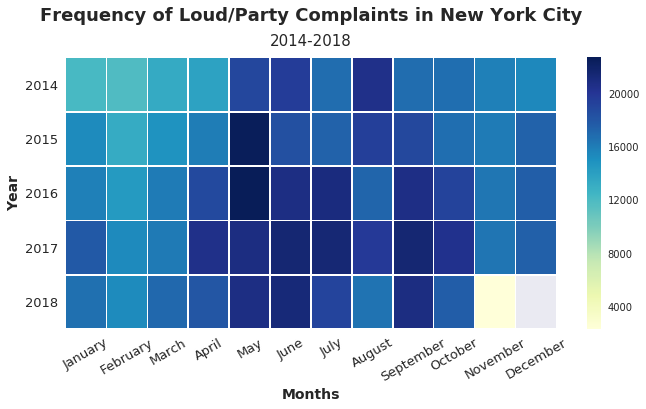

In [20]:
pl.figure(figsize=(11,5))
pl.suptitle('Frequency of Loud/Party Complaints in New York City',fontsize=18,fontweight='bold',y=1.02, x=0.435)
pl.title('2014-2018',fontsize=15,y=1.02)
sns.heatmap(table, linewidths=0.5, cmap='YlGnBu')
pl.xlabel('Months', fontsize=14, fontweight='bold')
pl.ylabel('Year', fontsize=14, fontweight='bold')
pl.xticks(rotation=30, fontsize=13)
pl.yticks(fontsize=13, rotation=0)
pl.show()

**Figure 1.** Loud/Party complaints frequencies through 311 calls data in New York City during 2014-2018. Areas with darker blue indicate higher frequency of loud/party complaints. This figure shows that within 2014 to 2018, there were more complaints during summer time.

### According to Wenjie Zheng, I changed my heatmap color from blue to red, also based on Urwa Muaz's suggestion, I delete the data in November and December so that the outlier will not affect the distribution of color spectrum.

In [21]:
table1 =table[['January', 'February', 'March', 'April', 'May','June','July','August','September','October']]
table1

Months,January,February,March,April,May,June,July,August,September,October
Year,,,,,,,,,,
2014,12205.0,11905.0,13339.0,13875.0,19036.0,19644.0,16884.0,20622.0,16856.0,16806.0
2015,15313.0,13284.0,14941.0,16083.0,22561.0,18419.0,17448.0,19478.0,18933.0,16737.0
2016,15930.0,14467.0,16121.0,18855.0,22704.0,20870.0,21058.0,17255.0,20792.0,19264.0
2017,17892.0,15444.0,16197.0,20559.0,20941.0,21578.0,21455.0,19812.0,21567.0,20465.0
2018,16683.0,15307.0,17064.0,18019.0,20816.0,21348.0,19168.0,16506.0,20934.0,17635.0


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


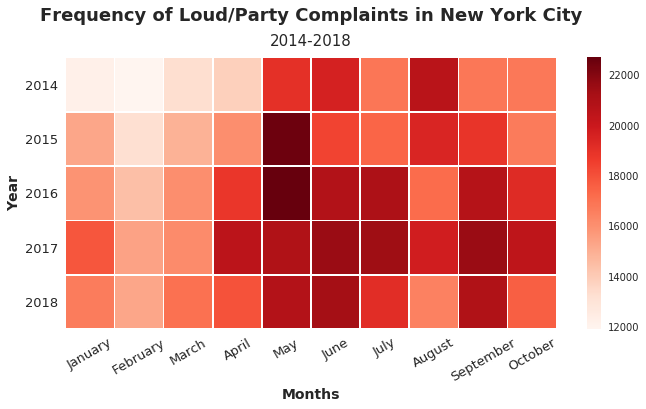

In [22]:
pl.figure(figsize=(11,5))
pl.suptitle('Frequency of Loud/Party Complaints in New York City',fontsize=18,fontweight='bold',y=1.02, x=0.435)
pl.title('2014-2018',fontsize=15,y=1.02)
sns.heatmap(table1, linewidths=0.5, cmap='Reds')
pl.xlabel('Months', fontsize=14, fontweight='bold')
pl.ylabel('Year', fontsize=14, fontweight='bold')
pl.xticks(rotation=30, fontsize=13)
pl.yticks(fontsize=13, rotation=0)
pl.show()

**Figure 2.** Loud/Party complaints frequencies through 311 calls data in New York City during 2014-2018. I changed colormap to reds, and also delete the outliers in November and December. Areas with darker red indicate higher frequency of loud/party complaints. This figure shows that within 2014 to 2018, there were more complaints during summer time. After removing the outliers, the contrast of different values among these years are more visible.